In [1]:
import torch
#TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
#CUDA_VERSION = torch.__version__.split("+")[-1]
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog,build_detection_test_loader, \
build_detection_train_loader

import matplotlib.pyplot as plt

In [3]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_f10217.pkl: 178MB [00:24, 7.16MB/s]                              
/home/appuser/detectron2_repo/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/appuser/.local/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0, 24],
       device='cuda:0')
Boxes(tensor([[126.6035, 244.8977, 459.8291, 480.0000],
        [251.1083, 157.8127, 338.9731, 413.6379],
        [114.8496, 268.6864, 148.2352, 398.8111],
        [  0.8217, 281.0327,  78.6072, 478.4210],
        [ 49.3954, 274.1229,  80.1545, 342.9808],
        [561.2248, 271.5816, 596.2755, 385.2552],
        [385.9072, 270.3125, 413.7130, 304.0397],
        [515.9295, 278.3744, 562.2792, 389.3802],
        [335.2409, 251.9167, 414.7491, 275.9375],
        [350.9300, 269.2060, 386.0984, 297.9081],
        [331.6292, 230.9996, 393.2759, 257.2009],
        [510.7349, 263.2656, 570.9865, 295.9194],
        [409.0841, 271.8646, 460.5582, 356.8722],
        [506.8766, 283.3257, 529.9403, 324.0392],
        [594.5663, 283.4820, 609.0577, 311.4124]], device='cuda:0'))


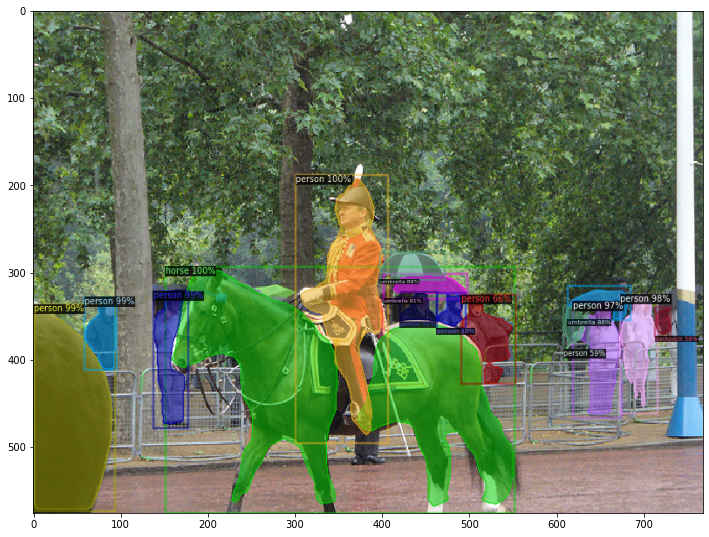

In [6]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(1, figsize=(12, 12))
plt.imshow(out.get_image())

# custom data

In [2]:
import torch
#TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
#CUDA_VERSION = torch.__version__.split("+")[-1]
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog,build_detection_test_loader, \
build_detection_train_loader

import matplotlib.pyplot as plt

In [3]:
data_dir = "/dataset"

In [4]:
levels = {'1': '불량', '2': '보통', '3': '우수'}
level_en = {'보통': 'normal', '불량': 'faulty', '우수': 'best'}
categories= {'C': '구조물',
 'F': '대지',
 'I': '단열',
 'L': '생활',
 'P': '구조물',
 'T': '마감',
 'W': '창호',
 'X': '철근노출'}
cat_en = {'구조물': 'struct',
 '단열': 'insul',
 '대지': 'ground',
 '마감': 'fin',
 '생활': 'living',
 '창호': 'win',
 '철근노출': 'rebar'}

In [5]:
cls_label_mapping={0: 'bg',
 1: 'insul',
 2: 'ground',
 3: 'living',
 4: 'struct',
 5: 'rebar',
 6: 'fin',
 7: 'win',
 8: 'living'}

label_cls_mapping ={'bg': 0,
 'fin': 6,
 'ground': 2,
 'insul': 1,
 'living': 8,
 'rebar': 5,
 'struct': 4,
 'win': 7}

In [6]:
error_files=[]
from detectron2.structures import BoxMode
from tqdm import tqdm
import os
import json
import numpy as np
import magic
import re

W_new, H_new = 540, 720
def process_dataset(data_dir):
    paths_filename = {}

    for root, dirs, files in tqdm(os.walk(data_dir), desc="Searching for files"):
        for file in files:
            paths_filename[file] = os.path.join(root, file)
    
    labels_names = sorted([f for f in paths_filename.keys() if f.endswith(".json")])
    images_names = sorted([f for f in paths_filename.keys() if f.endswith(".jpg")])
    
    print("Collecting processed files...")
    labels_paths = [paths_filename[name] for name in tqdm(labels_names)]
    images_paths = [paths_filename[name] for name in tqdm(images_names)]
    print("Done")

    dataset_dicts = []
    #classes = en_classes
    for img, label in tqdm(zip(images_paths, labels_paths), desc="Data processing"):
        f = open(os.path.join(data_dir, label), "r")
        json_data = json.load(f)['Learning data info']
        f.close()
        annotations = json_data['Annotations']
        json_id = json_data['Json data ID']
        
        _, _, cat, cls, img_type, _  = json_id.split("_")
   
        if img_type == "R":
            if not "RGB" in img:
                error_files.append(img)
                continue
            t = magic.from_file(img)
            W, H = re.search('(\d+)x(\d+)', t).groups()
            W, H = int(W), int(H)
       
            record = {}
            objs = []
            record["file_name"] = img
            record["image_id"] = img # use image name as id
            record["height"] = H_new
            record["width"] = W_new
            level = levels[cls]
            label = f"{cat_en[categories[cat]]}"
            cls = label_cls_mapping[label]
            
            
            for ant in annotations:
                ant_type = ant['Type']
                if ant_type == "polygon":
                    temp_arr = np.array(ant[ant_type]).reshape(len(ant[ant_type])//2, 2)
                    for i in range(len(temp_arr)):
                        temp_arr[i][0] = int((temp_arr[i][0]/W) * W_new)
                        temp_arr[i][1] = int((temp_arr[i][1]/H) * H_new)
                    xmin, ymin = np.min(temp_arr, axis=0)
                    xmax, ymax = np.max(temp_arr, axis=0)    
                    if xmin == xmax or ymin == ymax:
                        continue  
                    
                elif ant_type == "bbox":
                    xmin, ymin, xmax, ymax = ant[ant_type]
                    xmin, xmax = int((xmin/W) * W_new), int((xmax/W) * W_new)
                    ymin, ymax = int((ymin/H) * H_new), int((ymax/H) * H_new)
                    if xmin == xmax or ymin == ymax:
                        continue
                
                obj = {
                        "bbox":[xmin, ymin, xmax, ymax], 
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id":cls
                    }
                    
                objs.append(obj)
        
        
            if len(objs) == 0:
                continue
            record["annotations"] = objs
            dataset_dicts.append(record)
    
    print("인덱스, 클래스 맵핑", cls_label_mapping)
    print("클래스, 인덱스 맵핑", label_cls_mapping)
    return dataset_dicts

In [7]:
dataset_dicts=process_dataset(data_dir)

Searching for files: 713it [00:00, 1975.83it/s]


100%|██████████| 63732/63732 [00:00<00:00, 1691865.61it/s]


Done


Data processing: 63732it [02:17, 462.92it/s] 

인덱스, 클래스 맵핑 {0: 'bg', 1: 'insul', 2: 'ground', 3: 'living', 4: 'struct', 5: 'rebar', 6: 'fin', 7: 'win', 8: 'living'}
클래스, 인덱스 맵핑 {'bg': 0, 'fin': 6, 'ground': 2, 'insul': 1, 'living': 8, 'rebar': 5, 'struct': 4, 'win': 7}


In [8]:
len(error_files)

9833

In [9]:
error_files #에러 일어난 파일들 

['/dataset/raw/단독주택/구조물(균열)/우수/RGb/S-210901_H_C_1_R_9845018-13.jpg',
 '/dataset/raw/다세대주택/대지/보통/열화상/S-210908_M_F_2_T_3414018-1.jpg',
 '/dataset/raw/다세대주택/대지/보통/열화상/S-210908_M_F_2_T_3414018-10.jpg',
 '/dataset/raw/다세대주택/대지/보통/열화상/S-210908_M_F_2_T_3414018-11.jpg',
 '/dataset/raw/다세대주택/대지/보통/열화상/S-210908_M_F_2_T_3414018-12.jpg',
 '/dataset/raw/다세대주택/대지/보통/열화상/S-210908_M_F_2_T_3414018-13.jpg',
 '/dataset/raw/다세대주택/대지/보통/열화상/S-210908_M_F_2_T_3414018-14.jpg',
 '/dataset/raw/다세대주택/대지/보통/열화상/S-210908_M_F_2_T_3414018-15.jpg',
 '/dataset/raw/다세대주택/대지/보통/열화상/S-210908_M_F_2_T_3414018-16.jpg',
 '/dataset/raw/다세대주택/대지/보통/열화상/S-210908_M_F_2_T_3414018-17.jpg',
 '/dataset/raw/다세대주택/대지/보통/열화상/S-210908_M_F_2_T_3414018-18.jpg',
 '/dataset/raw/다세대주택/대지/보통/열화상/S-210908_M_F_2_T_3414018-19.jpg',
 '/dataset/raw/다세대주택/대지/보통/열화상/S-210908_M_F_2_T_3414018-2.jpg',
 '/dataset/raw/다세대주택/대지/보통/열화상/S-210908_M_F_2_T_3414018-20.jpg',
 '/dataset/raw/다세대주택/대지/보통/열화상/S-210908_M_F_2_T_3414018-21.jpg',
 '/dataset/raw/다세대주택/대지

In [10]:
import pickle

In [11]:
with open('dataset_dicts_faster.pickle', 'wb') as f:
    pickle.dump(dataset_dicts, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('dataset_dicts_faster.pickle', 'rb') as f:
    dataset_dicts = pickle.load(f)

In [12]:
n = len(dataset_dicts)
train, val, test = dataset_dicts[:int(0.8 * n)], dataset_dicts[int(0.8 * n):int(0.9 * n)], dataset_dicts[int(0.9 * n):]

In [13]:
def get_dataset(d):
    if d == "train":
        return train
    elif d == "val":
        return val
    elif d == "test":
        return test

In [14]:
DatasetCatalog.clear()

In [15]:
datasets = [train, val, test]
thing_classes = []

for i in range(len(cls_label_mapping)):
    thing_classes.append(cls_label_mapping[i])

for d, dataset in zip(["train", "val", "test"], datasets):
    DatasetCatalog.register("e8ight_" + d, lambda d=d: get_dataset(d))
    MetadataCatalog.get("e8ight_" + d).thing_classes=thing_classes
e8ight_metadata = MetadataCatalog.get("e8ight_train")

In [16]:
DatasetCatalog.get("e8ight_train")

[{'annotations': [{'bbox': [336, 188, 540, 720],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 2},
   {'bbox': [98, 186, 249, 720],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 2},
   {'bbox': [66, 410, 134, 720],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 2}],
  'file_name': '/dataset/raw/단독주택/대지/불량/RGB/S-210822_H_F_3_R_96367347051-1.jpg',
  'height': 720,
  'image_id': '/dataset/raw/단독주택/대지/불량/RGB/S-210822_H_F_3_R_96367347051-1.jpg',
  'width': 540},
 {'annotations': [{'bbox': [0, 0, 540, 719],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 2}],
  'file_name': '/dataset/raw/단독주택/대지/불량/RGB/S-210822_H_F_3_R_96367347051-10.jpg',
  'height': 720,
  'image_id': '/dataset/raw/단독주택/대지/불량/RGB/S-210822_H_F_3_R_96367347051-10.jpg',
  'width': 540},
 {'annotations': [{'bbox': [0, 0, 540, 720],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 2}],
  'file_name': '/dataset/raw/단독주택/대지/불량/RGB/S-210822_H_F_3_R_96367347051-12.jpg',
  '

# Train

In [22]:
from detectron2.engine import DefaultTrainer
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils
import copy

def custom_mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="RGB")
    transform_list = [T.Resize((W_new,H_new))]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


class E8ightTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)
    
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("e8ight_train",)
cfg.DATASETS.TEST = ("e8ight_val", )
cfg.DATALOADER.NUM_WORKERS = 4
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.OUTPUT_DIR = os.path.join(cfg.OUTPUT_DIR, "faster")

cfg.INPUT.FORMAT = "RGB"
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 50000   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.WARMUP_ITERS = 100
cfg.SOLVER.STEPS = [i for i in range(100, 3000, 50)]        
cfg.SOLVER.GAMMA = 0.98 #discount
cfg.SOLVER.CHECKPOINT_PERIOD = 5000 #save checkpoint

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(thing_classes)  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
#cfg.TEST.EVAL_PERIOD = 50 # No. of iterations after which the Validation Set is evaluated.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = E8ightTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.93 GiB total capacity; 6.11 GiB already allocated; 13.81 MiB free; 6.67 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
val_dataset = "e8ight_val"
evaluator = COCOEvaluator(val_dataset, cfg, False, output_dir="./output/faster/")
val_loader = build_detection_test_loader(cfg, val_dataset, mapper=custom_mapper)
inference_on_dataset(trainer.model, val_loader, evaluator)

# Inf eval

In [147]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # set a custom testing threshold

predictor = DefaultPredictor(cfg)

In [148]:
from detectron2.utils.visualizer import ColorMode
import random

def plot_img():
    for d in random.sample(train, 1):    
        img = plt.imread(d["file_name"])
        H, W, _ = img.shape

        im = cv2.resize(plt.imread(d["file_name"]), (W_new, H_new), interpolation=cv2.INTER_NEAREST)
        json_file = d["file_name"].replace("raw", "label").replace("jpg", "json")
        json_data = json.load(open(json_file, "r"))

        outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        #print(outputs)
        v = Visualizer(im,
                       metadata=e8ight_metadata, 
        )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.figure(1, figsize=(12, 12))

        img = out.get_image()

        for ant in json_data['Learning data info']['Annotations']:
            if ant['Type'] == 'polygon':
                continue
                #poly = ant['polygon']
                #poly = np.array(poly).reshape(len(poly)//2, 2)
                #for i in range(len(poly)):
                #    poly[i][0] = int((poly[i][0]/W) * W_new)
                #    poly[i][1] = int((poly[i][1]/H) * H_new)
                #cv2.polylines(img, [poly], False, (255, 0, 0), 2)
            else:
                x1, y1, x2, y2 = ant['bbox']
                x1, x2 = int((x1/W) * W_new), int((x2/W) * W_new)
                y1, y2 = int((y1/H) * H_new), int((y2/H) * H_new)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

        plt.imshow(img)       
            
            
    

/home/appuser/detectron2_repo/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


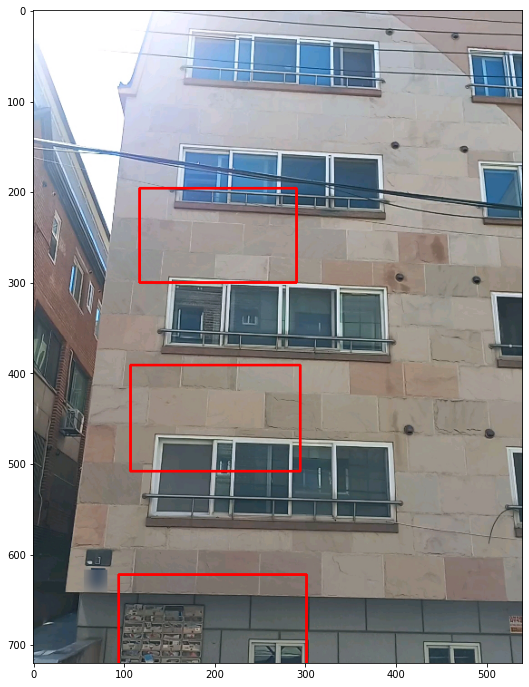

In [149]:
plot_img()

In [ ]:
print(outputs["instances"])

In [ ]:
print(outputs["instances"])